## Simple example of the EGCI calculation

juancolonna@icomp.ufam.edu.br

In [2]:
import numpy as np
from infromation_theory_utils import JSD, Entropy
import pandas as pd
import soundfile as sf
import os
from scipy.linalg import svd, toeplitz
from scipy.stats import zscore
from statsmodels.tsa.stattools import acf
from scipy.signal import spectrogram
import time
    
import matplotlib.pyplot as plt
%matplotlib inline

# E4E TODO
- Apply low pass filter to rainy data and see where it lands on the HxC Plane.
- Apply sampling rate reduction technique to achieve same goal (both to remove ultrasound range)
- Compare which techniques seem to be more desirable on rainy data.
- Do the same with cricket audio. 

# YJ TODO
- Apply different downsampling techniques and/or low pass filter and see if this makes a difference in the HxC plane (for rainy samples)
- Try to downsample a bunch of clips that don't have rain in them and see if downsampling places them onto blue curve (can try different downsampling techniques) 

## Introduction

This notebook shows how to calculate the EGCI index for some audio records found into GRABADOR-SDZG-AM-15 folder. These recordings have a maximum frequency of 384kHz.

### Loading the upper and lower boundaries

First, we have to choose the maximum time lag. Possible precalculated values are [32, 64, 128, 256, 512]. Other values are also possible, but the boundaries must be generated for these specific values using the script available at "generates_HxC_boundaries.ipynb"

In [3]:
lag = 512
cotas = pd.read_csv('./boundary_files/Cotas_HxC_bins_' + str(int(lag)) + '.csv')
noise = pd.read_csv('./coloredNoises/coloredNoises_' + str(int(lag)) + '.csv')

### Plotting one audio sample in .wav format

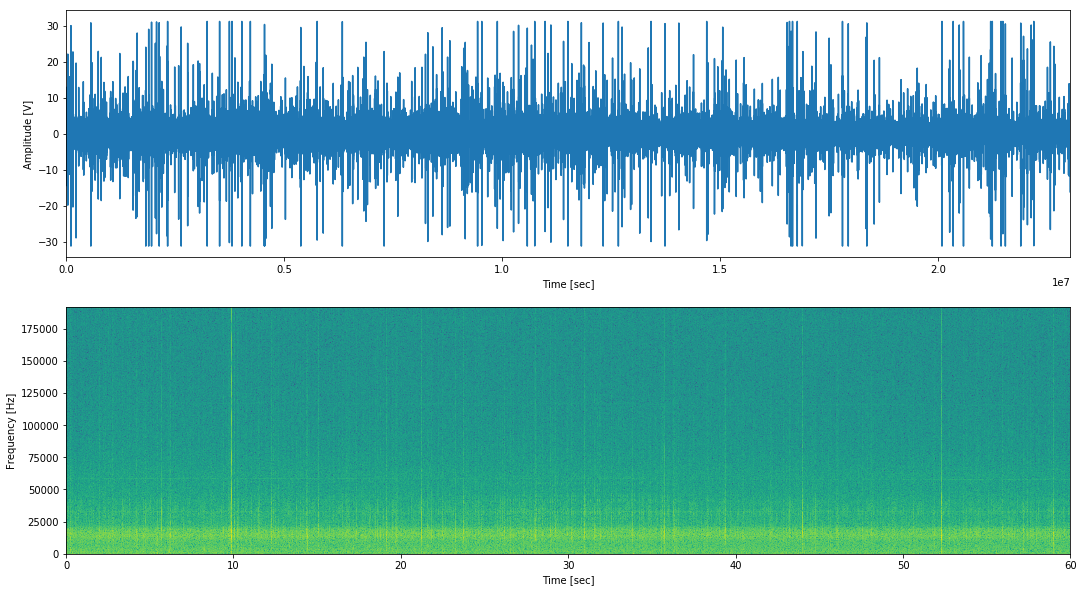

In [4]:
#datapath = './GRABADOR-SDZG-AM-15/'
#Seems to have errors when switching from mono to stereo data.
#datapath = 'C:/Users/Jacob/Desktop/Bioacoustics Project/ClusteredData/Clusters_GY01/Clusters_GY01/cluster_12/'
#datapath = "C:/Users/Jacob/Desktop/Bioacoustics Project/AudioMothData/GRABADOR-SDZG-AM-16/"
datapath = "./Rain/"
#x, fs = sf.read(datapath + '20190611_202000.WAV')
#x, fs = sf.read(datapath + '108.wav')
#x, fs = sf.read(datapath + '20190613_082000.WAV')
x, fs = sf.read(datapath + '20190614_110000.WAV')
x = zscore(x)

nfft = 1024 # allowed values = {64, 128, 256, 512, 1024, 2048}
# Power spectral density                      
f, t, Pxx = spectrogram(x, fs, nfft = nfft, nperseg = nfft, noverlap = nfft/2, window = 'hann', scaling = 'density')

plt.figure(figsize=(18,10))

plt.subplot(2,1,1)
plt.plot(x)
plt.xlim([0,len(x)])
plt.ylabel('Amplitude [V]')
plt.xlabel('Time [sec]')

plt.subplot(2,1,2)
plt.pcolormesh(t, f, np.log(Pxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# cb = plt.colorbar() # uncomment to see the colorbar
# cb.set_label('Power Spectral Density [dB]')
plt.show()

Observation: there are three frequency bands with virtually constant energy from the start to the end. These bands are between 32 ~ 33kHz, 90 ~ 91kHz and 180 ~ 182kHz and are repeated in all audio samples. My guess is that these frequency bands were generated by some Anthropogenic source of noise. I do not know to what extent this almost constant noise can cause a bias in the calculation of the EGCI.

### EGCI

Reading and processing all files in the folder and executing the steps of the algorithm described in the article https://www.biorxiv.org/content/10.1101/2020.02.09.940916v1

In [5]:
listing = os.listdir(datapath)

H = []
C = []
labels = []
#additional functionality to 
#f = open("./ECIComputerTimes.txt","w+")

for file in listing:
#    start = time.time()
    x, fs = sf.read(datapath + file)
    x = zscore(x)
    
    # Algorithm steps 
    #Auto-Correlation Matrix
    rxx = acf(x, nlags=lag, unbiased=True, fft=True)
    Sxx = toeplitz(rxx)
    #Singular Value Decomposition
    U, s, Vt = svd(Sxx)
    
    H.append(Entropy(s))              # Entropy
    C.append(Entropy(s)*JSD(s))       # Complexity, also called EGCI index
    labels.append(file.split('.')[0])  # Species name
#    end = time.time()
#    f.write(file + ": " + str(round(end - start,3)) + "\n")
#    f.close()

### Plotting the HxC plane

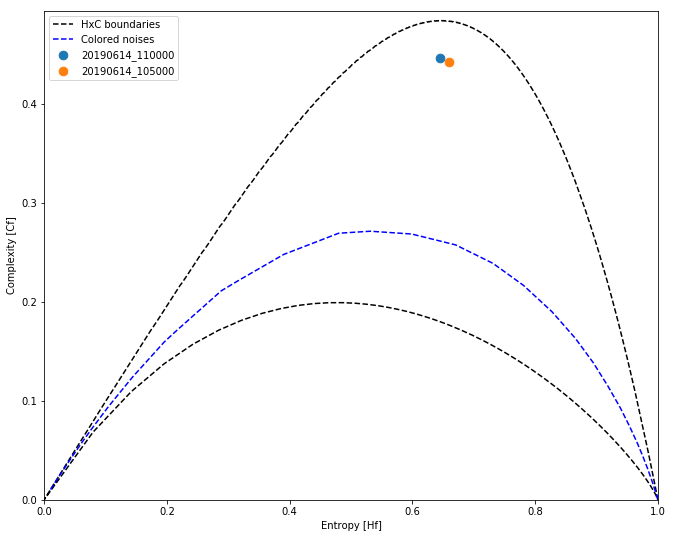

In [6]:
plt.figure(figsize=(11,9))

for i in range(len(H)):
    plt.scatter(H[i], C[i], marker='.', s=300, label = labels[i])

plt.plot(cotas['Entropy'],cotas['Complexity'], '--k', label = 'HxC boundaries')
plt.plot(noise['Entropy'],noise['Complexity'], '--b', label = 'Colored noises')
plt.xlim([0, 1])
plt.ylim([0, np.max(cotas['Complexity'])+0.01])
plt.ylabel('Complexity [Cf]')
plt.xlabel('Entropy [Hf]')
plt.legend(loc = 'best')
plt.show()

### Temporal ordering

In [6]:
indx = [labels.index(x) for x in sorted(labels)]
H_sorted = [H[labels.index(x)] for x in sorted(labels)]
C_sorted = [C[labels.index(x)] for x in sorted(labels)]
labels_sorted = sorted(labels)

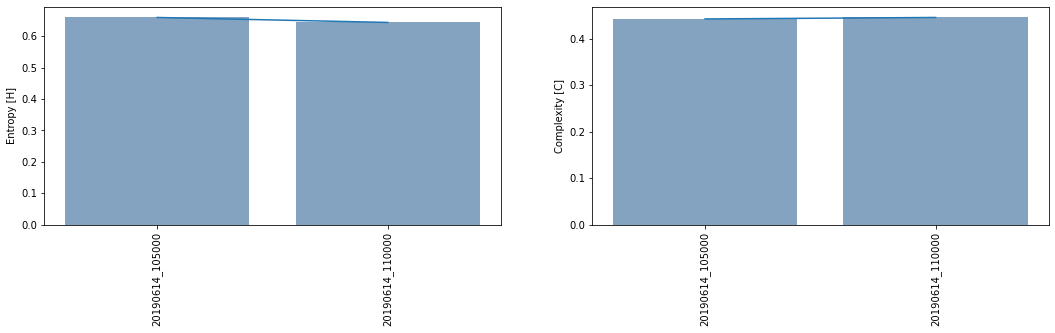

In [7]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.plot(H_sorted)
plt.bar(np.arange(len(H_sorted)), H_sorted, width=0.8, capsize=2, tick_label = labels_sorted, color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Entropy [H]')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.plot(C_sorted)
plt.bar(np.arange(len(C_sorted)), C_sorted, width=0.8, capsize=2, tick_label = labels_sorted, color=(0.2, 0.4, 0.6, 0.6))
plt.ylabel('Complexity [C]')
plt.xticks(rotation=90)
plt.show()

### Some comments

Comments valid for lag=512.

- Using time lag = 512 two main groups and an isolated sample can be observed. What caused this?

- Looking at the spectrogram of sample "20190611_215000", I realized that there is energy at high frequencies caused by some insect species (perhaps). I cannot say that this was the cause of the isolation, but the regular patterns observed in the spectrogram certainly decrease Entropy considerably. When one component of the signals stands out a lot from the others, then entropy is reduced. Unfortunately, I cannot hear this frequency band :-(

- Regarding sample "20190611_214000", I was able to hear some frogs, several insects, at least 5 different species of birds (parakeets perhaps) and background noise. Many different patterns causing an increase in complexity, as I expected. 

- A word of caution. I had never analyzed ultrasound samples, so I'm still not sure how to interpret the characteristics in the HxC plan.

- The samples are 60 sec long, I usually use shorter times (like 20 sec).

- It seems to me that the sequence of labels does not indicate contiguous times, so it is difficult to perform an analysis of the temporal evolution.

- I did not notice other environmental noises.